# Single Layer Perceptron (SLP) for MNIST Classification

This notebook implements a simple Single Layer Perceptron to classify handwritten digits from the MNIST dataset.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Softmax_fn = torch.nn.Softmax(dim=1)

def show_data(data_tuple):
    image, label = data_tuple
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis("off")

## Load MNIST Dataset

In [2]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n", train_dataset)

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

Print the training dataset:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Visualize Sample Images

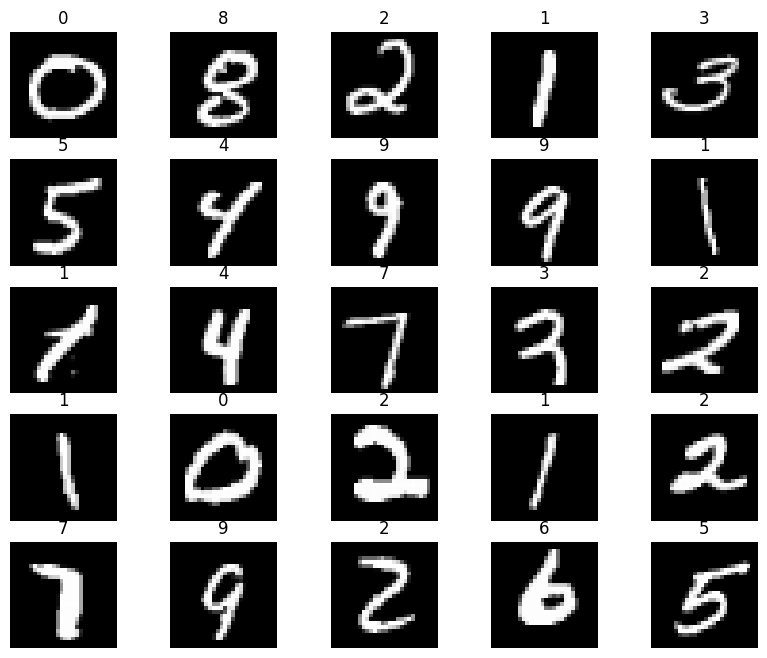

In [3]:
h = plt.figure(figsize=(10,8))
cols, rows = 5, 5
for i in range(1, cols*rows+1):
    random_idx = torch.randint(len(train_dataset), size=(1,)).item() 
    img, label = train_dataset[random_idx]
    h.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

## Define the SLP Model

In [4]:
class MLP(nn.Module):
    # Constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.out = nn.Linear(hidden_size, output_size)

    # Prediction
    def forward(self, x):
        x = self.hidden(x)
        pred = self.out(x)
        return pred

## Initialize Model and Set Device

In [5]:
input_dim = 28*28
hidden_dim = 20  # can adjust e.g. 32 or 130
output_dim = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
    device = "mps" if torch.backends.mps.is_available() else "cpu"

print("Using device:", device)

model = MLP(input_dim, hidden_dim, output_dim).to(device)
print('The model: \n', model)

Using device: cuda
The model: 
 MLP(
  (hidden): Sequential(
    (0): Linear(in_features=784, out_features=20, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=20, out_features=10, bias=True)
)


## Inspect Model Parameters

In [6]:
print('W: ', list(model.parameters())[0].size())
print('b: ', list(model.parameters())[1].size())

W:  torch.Size([20, 784])
b:  torch.Size([20])


In [7]:
model.state_dict()

OrderedDict([('hidden.0.weight',
              tensor([[ 0.0184, -0.0348,  0.0190,  ..., -0.0238,  0.0144,  0.0053],
                      [ 0.0063, -0.0161, -0.0274,  ..., -0.0242,  0.0245, -0.0098],
                      [ 0.0163,  0.0356, -0.0161,  ..., -0.0201, -0.0110, -0.0024],
                      ...,
                      [ 0.0090,  0.0077,  0.0127,  ...,  0.0058,  0.0014, -0.0019],
                      [ 0.0046,  0.0345,  0.0201,  ...,  0.0229, -0.0115, -0.0215],
                      [-0.0122,  0.0083, -0.0107,  ..., -0.0230,  0.0225,  0.0345]],
                     device='cuda:0')),
             ('hidden.0.bias',
              tensor([-0.0304, -0.0040, -0.0269, -0.0087, -0.0085,  0.0237,  0.0347, -0.0075,
                       0.0166, -0.0034, -0.0180, -0.0286,  0.0141, -0.0144, -0.0328,  0.0010,
                      -0.0284,  0.0126,  0.0141, -0.0311], device='cuda:0')),
             ('out.weight',
              tensor([[ 0.0789,  0.2021, -0.0908,  0.1076,  0.0439,  0

In [8]:
print('Hidden layer W: ', model.state_dict()['hidden.0.weight'].size())
print('Hidden layer b: ', model.state_dict()['hidden.0.bias'].size())
print('Output layer W: ', model.state_dict()['out.weight'].size())
print('Output layer b: ', model.state_dict()['out.bias'].size())

Hidden layer W:  torch.Size([20, 784])
Hidden layer b:  torch.Size([20])
Output layer W:  torch.Size([10, 20])
Output layer b:  torch.Size([10])


## Visualize Model Weights

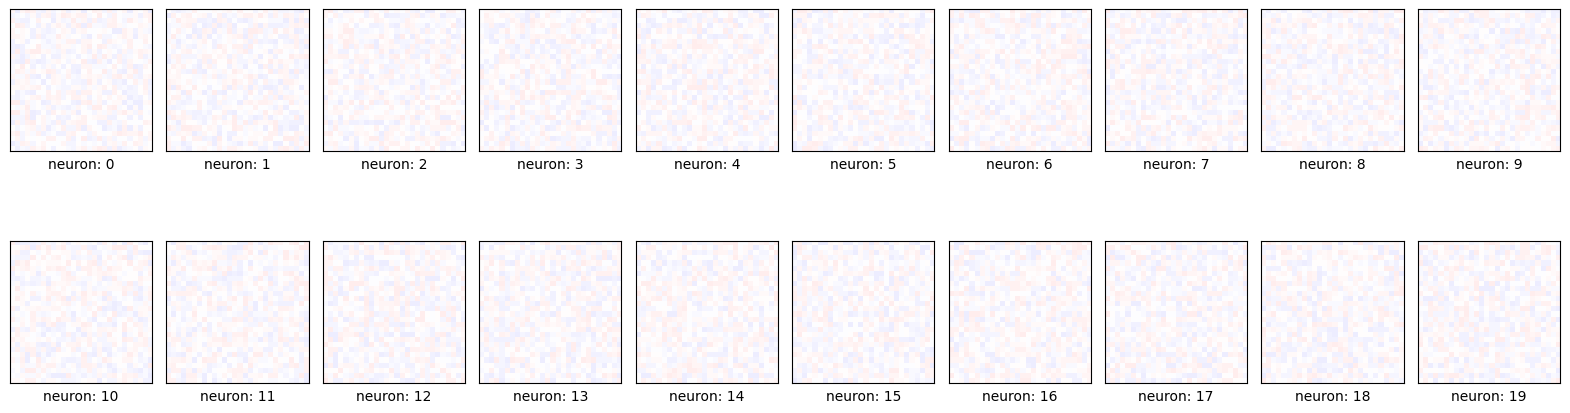

In [9]:
def PlotParameters(model, hiddenDim): 
    W = model.state_dict()['hidden.0.weight'].data.cpu()
    b = model.state_dict()['hidden.0.bias'].data.cpu()
    w_min = W.min().item()
    w_max = W.max().item()
    rows = int(np.ceil(hiddenDim/10.0))
    fig, axes = plt.subplots(rows, 10, figsize=(20, rows*3))
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    axes_flat = axes.flat if hasattr(axes, 'flat') else [axes]
    for i, ax in enumerate(axes_flat):
        if i < hiddenDim:
            ax.set_xlabel(f"neuron: {i}")
            Img = W[i, :].view(28, 28)
            ax.imshow(Img, vmin=-1, vmax=1, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

PlotParameters(model=model, hiddenDim=hidden_dim)

In [10]:
PlotParameters(model=model)

TypeError: PlotParameters() missing 1 required positional argument: 'hiddenDim'

## Setup Training Components

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Alternative:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_func = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True, num_workers=1)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=True, num_workers=1)

## Define Training Function

In [ ]:
# Initialize lists to track metrics
train_accuracy_list = []
loss_list = []

# Training function

def train(dataloader, model, loss_func, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, correct = 0, 0
    for batchNr, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X.view(-1, input_dim))
        loss = loss_func(pred, y)
        loss.backward()
        optimizer.step()
        _, yhat = torch.max(pred.data, 1)
        correct += (yhat == y).sum().item()
        train_loss += loss
        if (batchNr+1) % 100 == 0:
            loss_val, current = loss.item(), (batchNr+1)*len(y)
            print(f"loss: {loss_val:>7f} [{current:>5d}/{size:>5d}]")
    accuracy = correct / size
    train_accuracy_list.append(accuracy)
    loss_list.append(train_loss.item()/size)

10000
60000

Epoch 1
---------------------------------------------
loss: 0.661064 [10000/60000]
loss: 0.629819 [20000/60000]
loss: 0.674282 [30000/60000]
loss: 0.518831 [40000/60000]
loss: 0.489170 [50000/60000]
loss: 0.407333 [60000/60000]
Validation Error: 
 Accuracy: 90.3 Avg loss: 0.364544

Epoch 2
---------------------------------------------
loss: 0.233257 [10000/60000]
loss: 0.360710 [20000/60000]
loss: 0.498797 [30000/60000]
loss: 0.398818 [40000/60000]
loss: 0.388951 [50000/60000]
loss: 0.332466 [60000/60000]
Validation Error: 
 Accuracy: 91.3 Avg loss: 0.310832

Epoch 3
---------------------------------------------
loss: 0.196931 [10000/60000]
loss: 0.299383 [20000/60000]
loss: 0.449746 [30000/60000]
loss: 0.357343 [40000/60000]
loss: 0.347056 [50000/60000]
loss: 0.305991 [60000/60000]
Validation Error: 
 Accuracy: 91.9 Avg loss: 0.291580

Epoch 4
---------------------------------------------
loss: 0.185805 [10000/60000]
loss: 0.271633 [20000/60000]
loss: 0.423796 [30000/6000

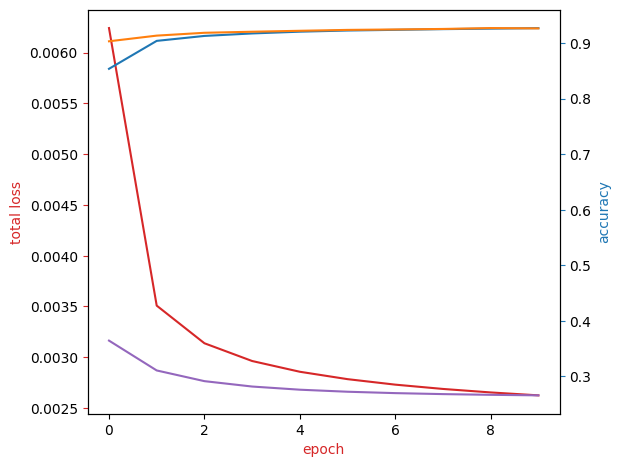

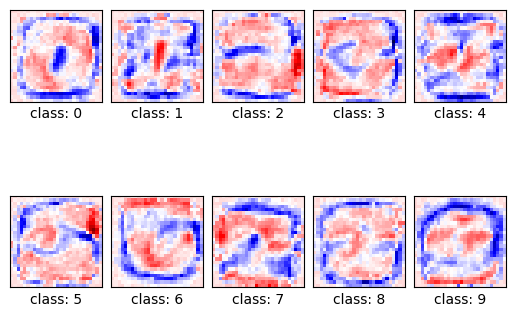

In [ ]:
val_loss_list = []
val_accuracy_list = []

# Validation function

def validate(dataloader, model, loss_func):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for x_test, y_test in dataloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            pred = model(x_test.view(-1, input_dim))
            val_loss += loss_func(pred, y_test)
            _, yhat = torch.max(pred.data, 1)
            correct += (yhat == y_test).sum().item()
    val_loss /= num_batches
    accuracy = correct / size
    val_accuracy_list.append(accuracy)
    val_loss_list.append(val_loss.item())
    print(f"Validation Error: \n Accuracy: {(100*accuracy):>0.1f} Avg loss: {(val_loss.item()):>8f}")

n_epochs = 10
loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
N_train = len(train_dataset)
N_test = len(validation_dataset)
print(N_test)
print(len(train_loader.dataset))

for t in range(n_epochs):
    print(f"n_epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_func, optimizer)
    validate(validation_loader, model, loss_func)
print("Done!")

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(train_accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
color = 'tab:orange'
ax2.plot(val_accuracy_list, color=color)
color = 'tab:purple'
ax2.plot(val_loss_list, color=color)

# Inference example
X, y = validation_dataset[63]
X = X.to(device)
label_tensor = torch.tensor([y], device=device)
z = model(X.reshape(-1, input_dim))
_, yhat = torch.max(z, 1)
yhat_int = int(yhat.item())
X_cpu = X.cpu()
show_data((X_cpu, y))
plt.show()
print("Predicted yhat:", yhat_int)
print("Raw logits z:", z)
print("Probability of predicted class", torch.max(Softmax_fn(z)).item())
print("Input reshaped:", X_cpu.shape)
hidden_out = model.hidden(X.reshape(-1, input_dim).to(device))
print("Hidden layer output shape:", hidden_out.shape)

b = model.state_dict()['hidden.0.bias'].data.cpu()
print("Bias sample (first 5):", b[:5])